## **0. Import libraries**

In [ ]:
import torch
import random
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

## **1. Prepare dataset**


In [ ]:
batch_size = 512

train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.46MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.6MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network**




In [ ]:
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x


class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

In [ ]:
first = MLP_2layers(input_dims=784, output_dims=128)
second = MLP_2layers(input_dims=128, output_dims=128)
third = MLP_2layers(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

## **3. Training 1**

In [ ]:
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3089, Train_Acc: 0.1159, Validation Loss: 1.3808, Val_Acc: 0.0978
EPOCH 2/100, Train_Loss: 2.2999, Train_Acc: 0.1364, Validation Loss: 1.3791, Val_Acc: 0.1318
EPOCH 3/100, Train_Loss: 2.2970, Train_Acc: 0.1663, Validation Loss: 1.3776, Val_Acc: 0.1617
EPOCH 4/100, Train_Loss: 2.2941, Train_Acc: 0.2004, Validation Loss: 1.3756, Val_Acc: 0.2182
EPOCH 5/100, Train_Loss: 2.2910, Train_Acc: 0.2327, Validation Loss: 1.3738, Val_Acc: 0.2385
EPOCH 6/100, Train_Loss: 2.2876, Train_Acc: 0.2653, Validation Loss: 1.3717, Val_Acc: 0.2300
EPOCH 7/100, Train_Loss: 2.2840, Train_Acc: 0.2510, Validation Loss: 1.3698, Val_Acc: 0.2822
EPOCH 8/100, Train_Loss: 2.2800, Train_Acc: 0.3216, Validation Loss: 1.3673, Val_Acc: 0.2482
EPOCH 9/100, Train_Loss: 2.2756, Train_Acc: 0.3202, Validation Loss: 1.3643, Val_Acc: 0.2895
EPOCH 10/100, Train_Loss: 2.2706, Train_Acc: 0.3372, Validation Loss: 1.3611, Val_Acc: 0.2850
EPOCH 11/100, Train_Loss: 2.2649, Train_Acc: 0.3558, Validation Loss:

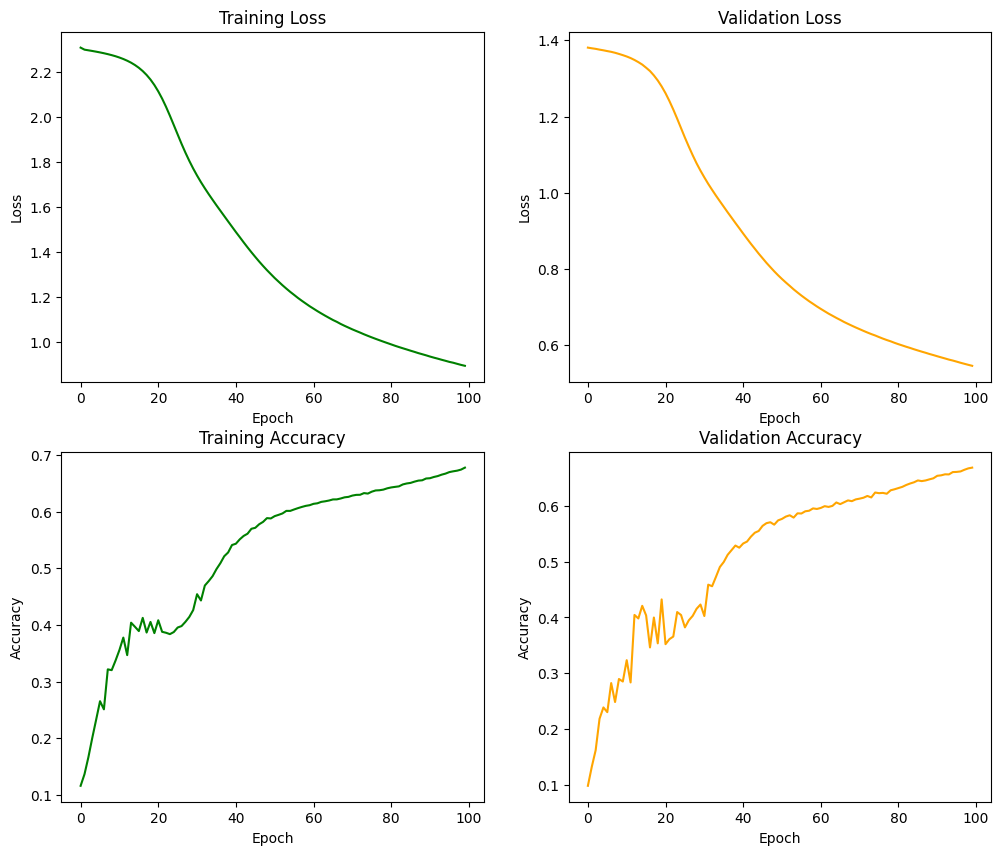

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **4. Training 2**

In [ ]:
for param in first.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3084, Train_Acc: 0.1068, Validation Loss: 1.3811, Val_Acc: 0.0937
EPOCH 2/100, Train_Loss: 2.3017, Train_Acc: 0.1053, Validation Loss: 1.3810, Val_Acc: 0.1012
EPOCH 3/100, Train_Loss: 2.3012, Train_Acc: 0.1076, Validation Loss: 1.3807, Val_Acc: 0.1757
EPOCH 4/100, Train_Loss: 2.3006, Train_Acc: 0.1237, Validation Loss: 1.3804, Val_Acc: 0.0895
EPOCH 5/100, Train_Loss: 2.3001, Train_Acc: 0.1246, Validation Loss: 1.3800, Val_Acc: 0.1678
EPOCH 6/100, Train_Loss: 2.2995, Train_Acc: 0.1311, Validation Loss: 1.3799, Val_Acc: 0.0895
EPOCH 7/100, Train_Loss: 2.2989, Train_Acc: 0.1632, Validation Loss: 1.3798, Val_Acc: 0.0895
EPOCH 8/100, Train_Loss: 2.2983, Train_Acc: 0.1551, Validation Loss: 1.3789, Val_Acc: 0.1623
EPOCH 9/100, Train_Loss: 2.2977, Train_Acc: 0.1663, Validation Loss: 1.3784, Val_Acc: 0.1748
EPOCH 10/100, Train_Loss: 2.2970, Train_Acc: 0.1902, Validation Loss: 1.3783, Val_Acc: 0.0895
EPOCH 11/100, Train_Loss: 2.2963, Train_Acc: 0.1752, Validation Loss:

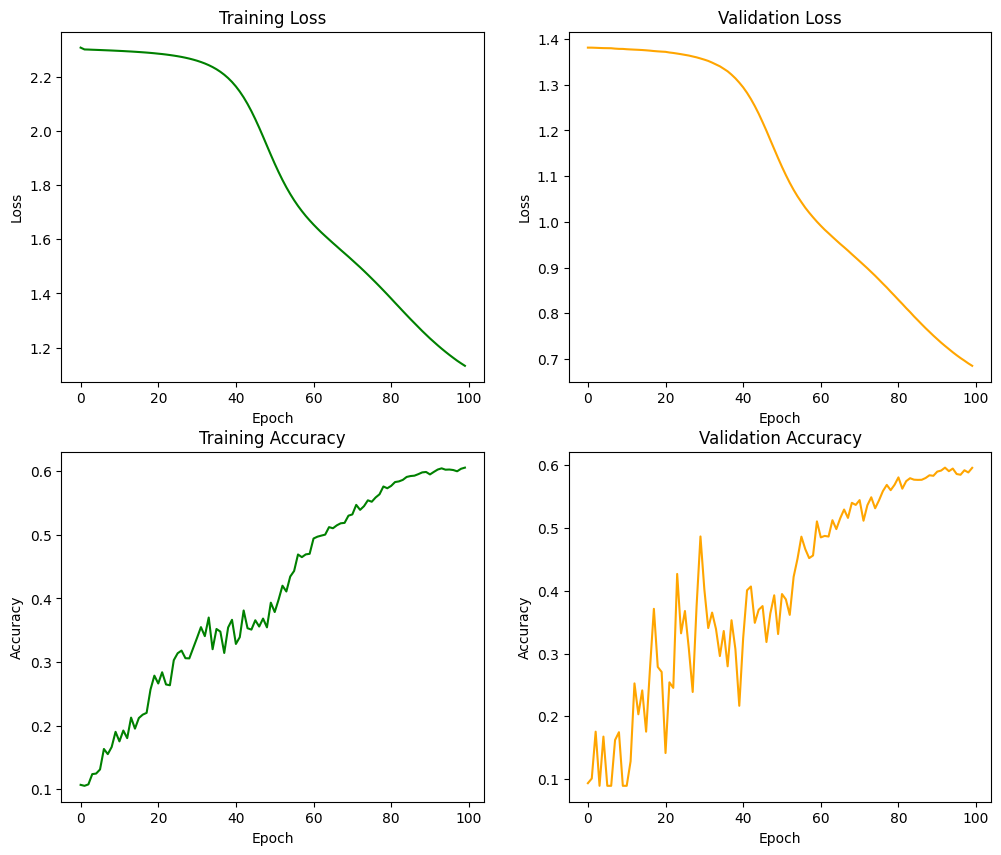

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **5. Training 3**

In [ ]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3096, Train_Acc: 0.0985, Validation Loss: 1.3819, Val_Acc: 0.0997
EPOCH 2/100, Train_Loss: 2.3029, Train_Acc: 0.0992, Validation Loss: 1.3819, Val_Acc: 0.0895
EPOCH 3/100, Train_Loss: 2.3026, Train_Acc: 0.1020, Validation Loss: 1.3816, Val_Acc: 0.1020
EPOCH 4/100, Train_Loss: 2.3022, Train_Acc: 0.1130, Validation Loss: 1.3814, Val_Acc: 0.0937
EPOCH 5/100, Train_Loss: 2.3018, Train_Acc: 0.1087, Validation Loss: 1.3809, Val_Acc: 0.0895
EPOCH 6/100, Train_Loss: 2.3015, Train_Acc: 0.1264, Validation Loss: 1.3811, Val_Acc: 0.0895
EPOCH 7/100, Train_Loss: 2.3011, Train_Acc: 0.1126, Validation Loss: 1.3807, Val_Acc: 0.1872
EPOCH 8/100, Train_Loss: 2.3007, Train_Acc: 0.1231, Validation Loss: 1.3808, Val_Acc: 0.0895
EPOCH 9/100, Train_Loss: 2.3003, Train_Acc: 0.1253, Validation Loss: 1.3800, Val_Acc: 0.1000
EPOCH 10/100, Train_Loss: 2.2999, Train_Acc: 0.1257, Validation Loss: 1.3799, Val_Acc: 0.1020
EPOCH 11/100, Train_Loss: 2.2995, Train_Acc: 0.1456, Validation Loss:

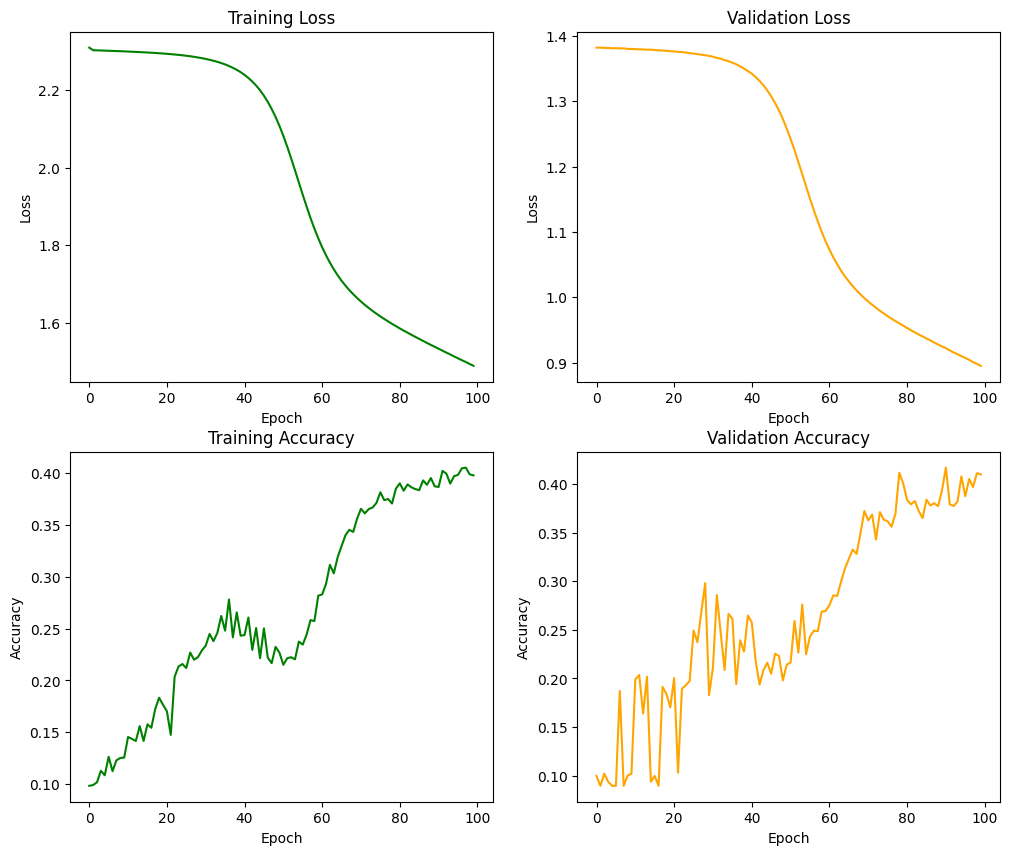

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **6. Training 4**


In [ ]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.1646, Train_Acc: 0.2134, Validation Loss: 1.2336, Val_Acc: 0.2032
EPOCH 2/100, Train_Loss: 1.9828, Train_Acc: 0.2132, Validation Loss: 1.1540, Val_Acc: 0.2228
EPOCH 3/100, Train_Loss: 1.8777, Train_Acc: 0.2299, Validation Loss: 1.1055, Val_Acc: 0.2505
EPOCH 4/100, Train_Loss: 1.8109, Train_Acc: 0.2497, Validation Loss: 1.0738, Val_Acc: 0.2438
EPOCH 5/100, Train_Loss: 1.7659, Train_Acc: 0.2612, Validation Loss: 1.0516, Val_Acc: 0.2687
EPOCH 6/100, Train_Loss: 1.7339, Train_Acc: 0.2872, Validation Loss: 1.0355, Val_Acc: 0.2708
EPOCH 7/100, Train_Loss: 1.7100, Train_Acc: 0.3007, Validation Loss: 1.0229, Val_Acc: 0.2878
EPOCH 8/100, Train_Loss: 1.6911, Train_Acc: 0.2980, Validation Loss: 1.0127, Val_Acc: 0.3017
EPOCH 9/100, Train_Loss: 1.6754, Train_Acc: 0.3178, Validation Loss: 1.0040, Val_Acc: 0.3058
EPOCH 10/100, Train_Loss: 1.6617, Train_Acc: 0.3224, Validation Loss: 0.9963, Val_Acc: 0.3207
EPOCH 11/100, Train_Loss: 1.6492, Train_Acc: 0.3350, Validation Loss:

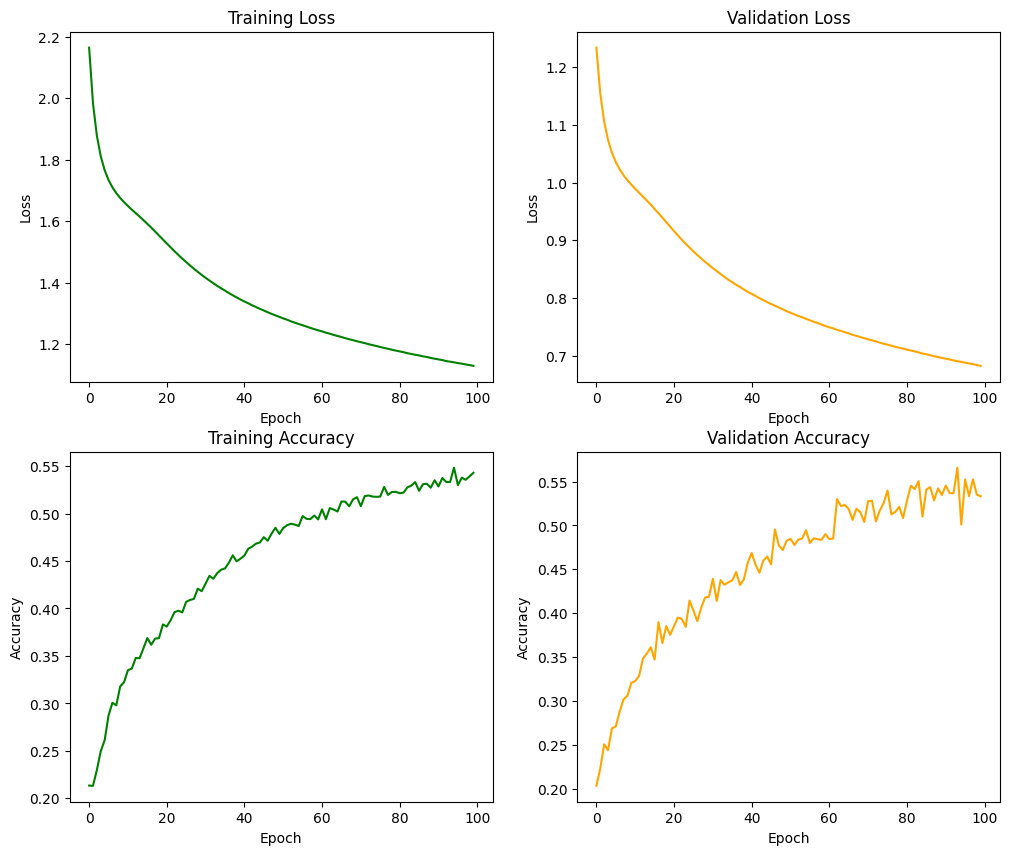

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **7. Training 4**


In [ ]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False
for param in third.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.2909, Train_Acc: 0.1711, Validation Loss: 1.3635, Val_Acc: 0.1848
EPOCH 2/100, Train_Loss: 2.2578, Train_Acc: 0.2241, Validation Loss: 1.3463, Val_Acc: 0.2140
EPOCH 3/100, Train_Loss: 2.2267, Train_Acc: 0.2728, Validation Loss: 1.3260, Val_Acc: 0.2672
EPOCH 4/100, Train_Loss: 2.1889, Train_Acc: 0.2564, Validation Loss: 1.3013, Val_Acc: 0.2765
EPOCH 5/100, Train_Loss: 2.1432, Train_Acc: 0.2663, Validation Loss: 1.2720, Val_Acc: 0.2615
EPOCH 6/100, Train_Loss: 2.0905, Train_Acc: 0.2493, Validation Loss: 1.2390, Val_Acc: 0.2723
EPOCH 7/100, Train_Loss: 2.0329, Train_Acc: 0.2647, Validation Loss: 1.2038, Val_Acc: 0.2738
EPOCH 8/100, Train_Loss: 1.9734, Train_Acc: 0.2811, Validation Loss: 1.1688, Val_Acc: 0.2950
EPOCH 9/100, Train_Loss: 1.9158, Train_Acc: 0.3009, Validation Loss: 1.1356, Val_Acc: 0.3152
EPOCH 10/100, Train_Loss: 1.8624, Train_Acc: 0.3117, Validation Loss: 1.1050, Val_Acc: 0.3347
EPOCH 11/100, Train_Loss: 1.8140, Train_Acc: 0.3354, Validation Loss:

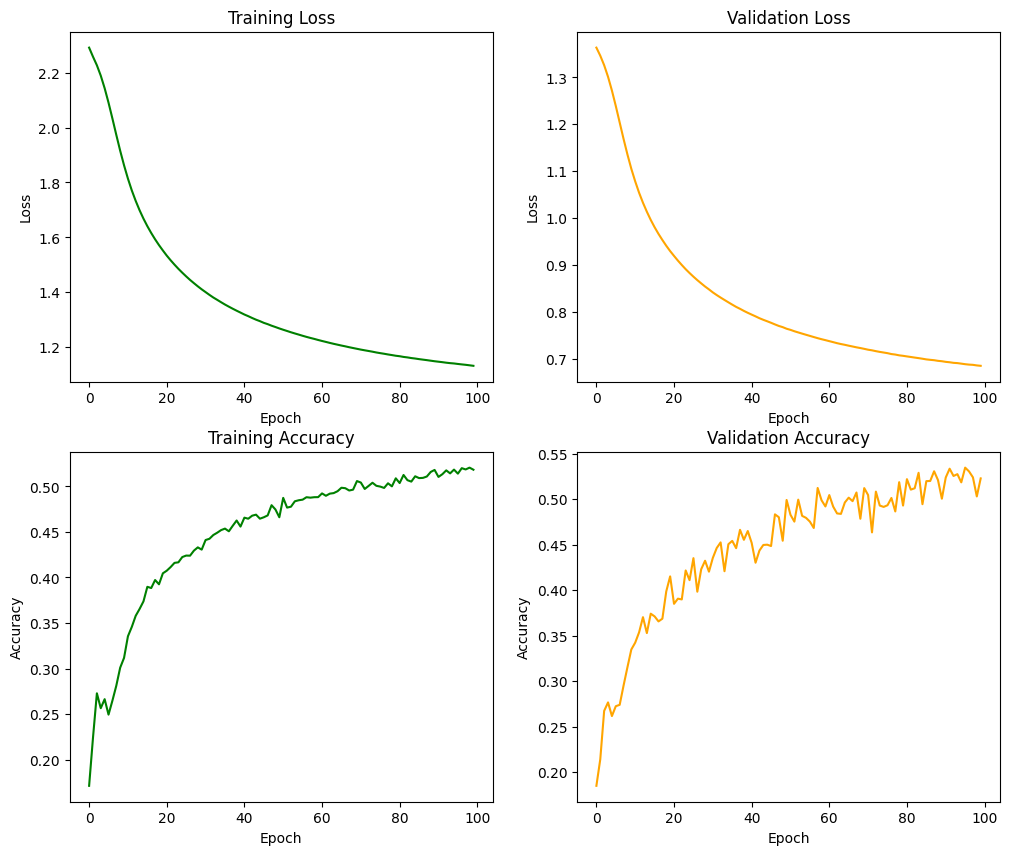

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **8. Training 6**


In [ ]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True
for param in third.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.1120, Train_Acc: 0.2912, Validation Loss: 1.1468, Val_Acc: 0.3403
EPOCH 2/100, Train_Loss: 1.8059, Train_Acc: 0.3565, Validation Loss: 1.0385, Val_Acc: 0.3963
EPOCH 3/100, Train_Loss: 1.6735, Train_Acc: 0.3913, Validation Loss: 0.9811, Val_Acc: 0.3763
EPOCH 4/100, Train_Loss: 1.5954, Train_Acc: 0.3931, Validation Loss: 0.9434, Val_Acc: 0.3825
EPOCH 5/100, Train_Loss: 1.5414, Train_Acc: 0.4040, Validation Loss: 0.9153, Val_Acc: 0.3995
EPOCH 6/100, Train_Loss: 1.5000, Train_Acc: 0.4084, Validation Loss: 0.8937, Val_Acc: 0.4288
EPOCH 7/100, Train_Loss: 1.4670, Train_Acc: 0.4096, Validation Loss: 0.8758, Val_Acc: 0.3963
EPOCH 8/100, Train_Loss: 1.4394, Train_Acc: 0.4157, Validation Loss: 0.8606, Val_Acc: 0.4433
EPOCH 9/100, Train_Loss: 1.4157, Train_Acc: 0.4219, Validation Loss: 0.8474, Val_Acc: 0.4377
EPOCH 10/100, Train_Loss: 1.3951, Train_Acc: 0.4329, Validation Loss: 0.8365, Val_Acc: 0.4225
EPOCH 11/100, Train_Loss: 1.3770, Train_Acc: 0.4371, Validation Loss:

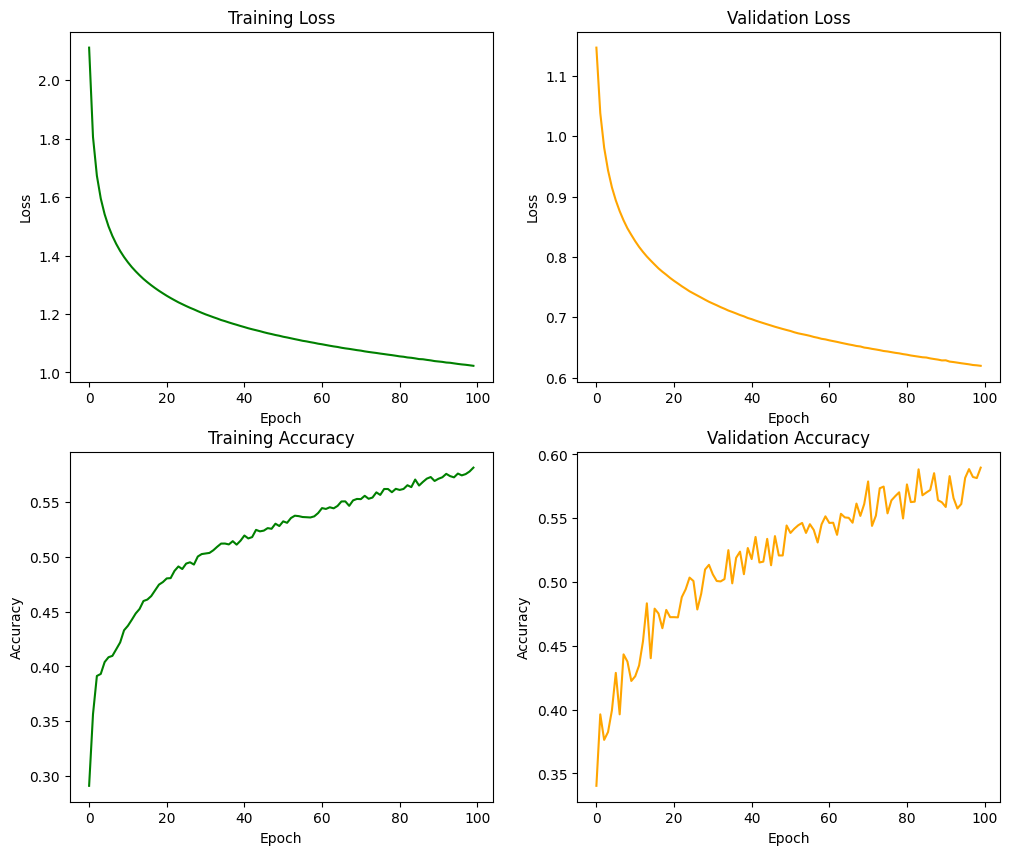

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **9. Evaluation**

In [ ]:
val_target = []
val_predict = []

model.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        outputs = model(X_val)

        val_predict.append(outputs.cpu())
        val_target.append(y_val.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = (torch.argmax(val_predict, 1) == val_target).sum().item() / len(val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.41


In [ ]:
test_target = []
test_predict = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.4202
